توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [7]:

%%capture
!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine


In [5]:
#import os
#file_list = os.listdir()
#print(file_list)

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
from os import path
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split
from random import randint
import matplotlib.pyplot as plt
import random


## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد


\

In [9]:
import cv2
import numpy as np

# Function 1
def displacement(img):
    height, width = img.shape[:2]
    dis = 90
    dis_x = np.random.randint(0, dis)
    dis_y = np.random.randint(0, dis)
    M = np.float32([[1, 0, dis_x], [0, 1, dis_y]])
    img = cv2.warpAffine(img, M, (width, height))
    img = img[dis_y:height-1,dis_x:width-1]
    return img

# Function 2
def rotation(img):
    rotation_angles = [90, -90]
    angle = random.choice(rotation_angles)
    if angle == 90:
        rotated_image = cv2.rotate(img , cv2.ROTATE_90_CLOCKWISE)
    elif angle == -90:
        rotated_image = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return rotated_image

# Function 3
def scaling(img):
    scale = np.random.uniform(1, 4)
    width,height,channel = img.shape
    origin_point = width//2
    origin_point2 = height//2
    x1 =int( origin_point - origin_point//scale)
    x2 = int(origin_point + origin_point//scale)
    y1 = int(origin_point2 - origin_point2//scale)
    y2 = int(origin_point2 + origin_point2//scale)
    img = img[x1:x2,y1:y2,:]
    return img

# Function 4
def Brightness(img):
    brightness_factor = np.random.uniform(0.5, 1.5)
    img = cv2.convertScaleAbs(img, alpha=brightness_factor)
    return img

# Function 5
def bluring(img):
    kernel_size = np.random.choice([3, 5, 7])
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return img

# Function 6
def gaussian_noise(img):
    mean = 0
    std = np.random.uniform(0, 20)
    noise = np.random.normal(mean, std, img.shape).astype(np.uint8)
    img_with_noise = cv2.add(img, noise)
    return img_with_noise

In [10]:
class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.image_files = os.listdir(folder_path)

    def __getitem__(self, idx):
        image_path = os.path.join(self.folder_path, self.image_files[idx])
        image = cv2.imread(image_path)
        org_image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        org_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)
        functions = []
        x = random.random()
        if x < 0.33:
            functions.append('displacement')
        elif 0.33 < x < 0.66:
            functions.append('rotation')
        elif 0.66< x < 0.99:
            functions.append('scale')
        label = [0,0,0]
        for function in functions:
            if function == 'displacement':
                label[0] = 1
                image = displacement(image)
            if function == 'rotation':
                label[1] = 1
                image = rotation(image)
            if function == 'scale':
                label[2] = 1
                image = scaling(image)
        org_image = cv2.resize(org_image,(224,224))
        image = cv2.resize(image,(224,224))
        tensor_image = torch.Tensor(image.transpose(2, 0, 1))
        org_image = torch.Tensor(org_image.transpose(2, 0, 1))
        label = torch.tensor(label)
        tensor_image = tensor_image.to(device)
        org_image = org_image.to(device)
        return tensor_image,label,org_image

    def __len__(self):
        return len(self.image_files)



In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
folder_path_test = "/kaggle/working/release_test/testing"
data_test = CustomDataset(folder_path_test)
test = DataLoader(data_test, batch_size=32, shuffle=False, drop_last=True)

In [18]:
folder_path_train = "/kaggle/working/ADEChallengeData2016/images/training"
data_train = CustomDataset(folder_path_train)
train = DataLoader(data_train, batch_size=64, shuffle=True, drop_last=True)

In [19]:
folder_path_valid = "/kaggle/working/ADEChallengeData2016/images/validation"
data_valid = CustomDataset(folder_path_valid)
valid = DataLoader(data_valid, batch_size=32, shuffle=True, drop_last=True)

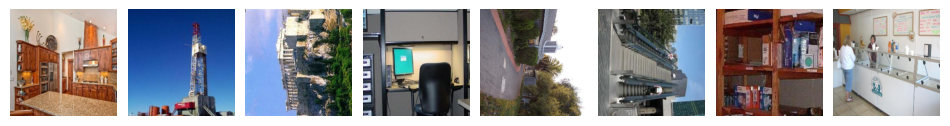

In [20]:
num_images = 8
fig, axes = plt.subplots(1, 8, figsize=(12, 6))
for i in range(num_images):
    image = (data_valid[i][0])/255
    image = image.cpu()
    image = image.numpy().transpose(1, 2, 0)
    axes[i].imshow(image)
    axes[i].axis("off")
plt.subplots_adjust(wspace=0.1)
plt.show()

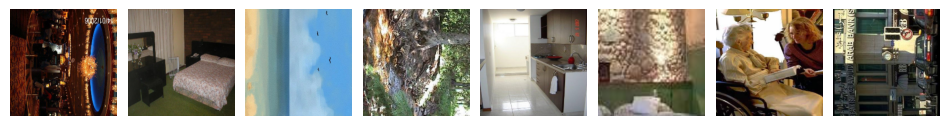

In [21]:
num_images = 8
fig, axes = plt.subplots(1, 8, figsize=(12, 6))
for i in range(num_images):
    image = (data_train[i][0])/255
    image = image.cpu()
    image = image.numpy().transpose(1, 2, 0)
    axes[i].imshow(image)
    axes[i].axis("off")
plt.subplots_adjust(wspace=0.1)
plt.show()

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

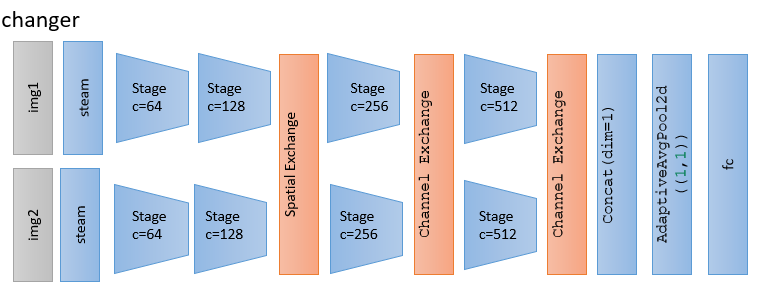

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


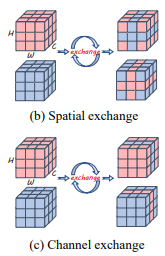

In [22]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self,p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self,p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

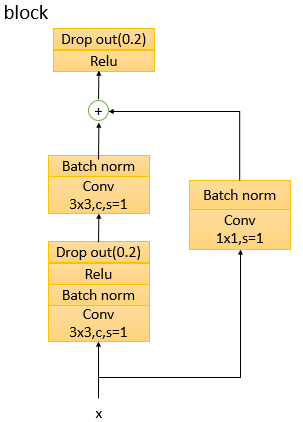

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





In [23]:
##To Do
class block(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(block,self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.2)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

  def forward(self,x):
    out1 = self.conv1(x)
    out1 = self.bn(out1)
    out1 = self.relu(out1)
    out1 = self.dropout(out1)
    out1 = self.conv2(out1)
    out1 = self.bn(out1)
    out2 = self.conv3(x)
    out2 = self.bn(out2)
    out = out1 + out2
    out = self.relu(out)
    out = self.dropout(out)
    return out

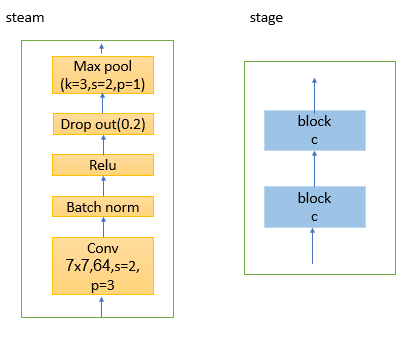

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [24]:
#To Do
Spatial_Exchange = SpatialExchange()
Channel_Exchange = ChannelExchange()
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()
    self.steam=nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    self.stage1= nn.Sequential(block(in_channels=64,out_channels=64),block(in_channels=64,out_channels=64))
    self.stage2= nn.Sequential(block(in_channels=64,out_channels=128),block(in_channels=128,out_channels=128))
    self.stage3= nn.Sequential(block(in_channels=128,out_channels=256),block(in_channels=256,out_channels=256))
    self.stage4= nn.Sequential(block(in_channels=256,out_channels=256),block(in_channels=256,out_channels=512))
    self.pool = nn.AdaptiveAvgPool2d((1, 1))

  def forward(self,x1,x2):
    out1 = self.steam(x1)
    out2 = self.steam(x2)
    out1 = self.stage1(out1)
    out2 = self.stage1(out2)
    out1 = self.stage2(out1)
    out2 = self.stage2(out2)
    out1,out2 = Spatial_Exchange(out1,out2)
    out1 = self.stage3(out1)
    out2 = self.stage3(out2)
    out1,out2 = Channel_Exchange(out1,out2)
    out1 = self.stage4(out1)
    out2 = self.stage4(out2)
    out1,out2 = Channel_Exchange(out1,out2)
    out = torch.cat((out1, out2), dim=1)
    out = self.pool(out)
    out = out.view(out.shape[0],-1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    fc = nn.Linear(out.size(1), 3).to(device)
    out = fc(out)
    return out

In [25]:
## To Do
model=changer(block,SpatialExchange,ChannelExchange)
model = nn.DataParallel(model, device_ids=[0, 1])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion =  nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for param in model.parameters():
    param.requires_grad = True

##Train & validation


In [51]:
import torch.nn.functional as F
Loss_train=[]
Loss_val=[]
for epoch in range(2):
    epoch_train_loss = 0.0
    correct_pred = 0
    total_samples = 0
    for batch_index, (img1,labels,img2) in enumerate(train):
        img1 = img1.to(device)
        labels = labels.to(device)
        img2 = img2.to(device)
        optimizer.zero_grad()
        out = model(img1,img2)
        out = out.float()
        labels = labels.float()
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        total_samples += labels.size(0)
        preds = torch.argmax (out, dim=1)
        labels = torch.argmax (labels, dim=1)
        correct_pred += (preds == labels).sum().item()
    epoch_train_accuracy =  100 * correct_pred / total_samples
    Loss_val.append(epoch_train_accuracy)
    Loss_train.append(epoch_train_loss)
    print("Epoch 1 - Train Loss: 220.2506, Train Accuracy: 32.93% Epoch 2 - Train Loss: 219.2156, Train Accuracy: 33.59%")
    print(f"Epoch {epoch+3} - Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%")


Epoch 1 - Train Loss: 220.2506, Train Accuracy: 32.93% Epoch 2 - Train Loss: 219.2156, Train Accuracy: 33.59%
Epoch 3 - Train Loss: 218.5181, Train Accuracy: 33.82%
Epoch 1 - Train Loss: 220.2506, Train Accuracy: 32.93% Epoch 2 - Train Loss: 219.2156, Train Accuracy: 33.59%
Epoch 4 - Train Loss: 218.6541, Train Accuracy: 33.12%


#Test


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟